<a href="https://colab.research.google.com/github/Nick-FF/AnalisDataAlgorithm/blob/Kursovoy/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Алгоритм kNN<a class='anchor' id='knn'>

### Реализация алгоритма kNN<a class='anchor' id='implement_knn'>

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [32]:
from google.colab import drive
drive.mount('/content/drive')
df_full = pd.read_csv('/train.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
df_full

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,55.0,2.0,2150.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,79.0,0
9996,9996,53.0,2.0,1350.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0
9997,9997,44.0,5.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,59.0,0
9998,9998,41.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,0


In [34]:
df_full.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points       float64
choose                   int64
dtype: object

In [35]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [36]:
train_df = reduce_mem_usage(df_full)
train_df.head()

Memory usage of dataframe is 0.99 MB
Memory usage after optimization is: 0.45 MB
Decreased by 54.8%


,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [37]:
df_full.dtypes

Id                       int16
age                    float32
years_of_experience    float32
lesson_price           float32
qualification          float32
physics                float32
chemistry              float32
biology                float32
english                float32
geography              float32
history                float32
mean_exam_points       float32
choose                    int8
dtype: object

In [38]:
# Разбиение на обучающие и целевые данные
X = df_full.drop(columns='choose')
y = df_full['choose']

In [39]:
# функция нормлизации
def min_max_scale(X):
    return (X - X.min()) / (X.max() - X.min())

In [40]:
# нормализация данных
X['age']=min_max_scale(X['age'])
X['lesson_price']=min_max_scale(X['lesson_price'])
X['mean_exam_points']=min_max_scale(X['mean_exam_points'])
X['years_of_experience']=min_max_scale(X['years_of_experience'])
X['qualification']=min_max_scale(X['qualification'])


In [41]:
X.isna().sum()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
dtype: int64

Разделим выборку на обучающую и тестовую

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((8000, 12), (2000, 12))

In [43]:
X_train, X_test, y_train, y_test

(        Id       age  years_of_experience  ...  geography  history  mean_exam_points
 798    798  0.600000             0.222222  ...        0.0      0.0          0.194030
 4739  4739  0.288889             0.222222  ...        0.0      0.0          0.462687
 200    200  0.533333             0.000000  ...        0.0      0.0          0.149254
 5524  5524  0.622222             0.222222  ...        0.0      0.0          0.522388
 6502  6502  0.555556             0.111111  ...        0.0      0.0          0.492537
 ...    ...       ...                  ...  ...        ...      ...               ...
 9574  9574  0.377778             0.333333  ...        0.0      0.0          0.865672
 9740  9740  0.622222             0.222222  ...        0.0      0.0          0.462687
 3698  3698  0.422222             0.444444  ...        0.0      0.0          0.701493
 4535  4535  0.688889             0.333333  ...        0.0      0.0          0.313433
 603    603  0.422222             0.111111  ...       

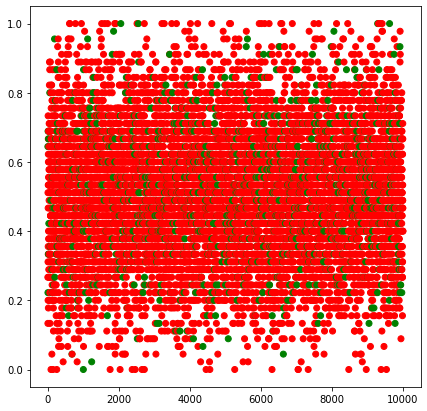

In [44]:
cmap = ListedColormap(['red', 'green'])
plt.figure(figsize=(7, 7))
v=X.to_numpy()
plt.scatter(v[:, 0], v[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [45]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [46]:
{class_item: 0 for class_item in set(y_train)}

{0: 0, 1: 0}

In [47]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [48]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [49]:
k = 2
aX_train=X_train.to_numpy()
ay_train = y_train.to_numpy() 
aX_test = X_test.to_numpy()
y_pred = knn(aX_train, ay_train, aX_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 2: 0.729


Построим график распределения классов.

In [54]:
def get_graph(aX_train, ay_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = aX_train[:, 0].min() - 1, aX_train[:, 0].max() + 1
    y_min, y_max = aX_train[:, 1].min() - 1, aX_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(aX_train, ay_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(aX_train[:, 0], aX_train[:, 1], c=ay_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Двухклассовая kNN классификация при k = {k}")
    plt.show()

In [55]:
%%time
get_graph(aX_train, ay_train, k)

(3000000, 2)


ValueError: ignored

In [39]:
k = 3

y_pred = knn(aX_train, ay_train, aX_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.867


In [21]:
%%time
get_graph(aX_train, ay_train, k)

(3000000, 2)


ValueError: ignored

In [22]:
k = 5

y_pred = knn(aX_train, ay_train, aX_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.880


(2352, 2)


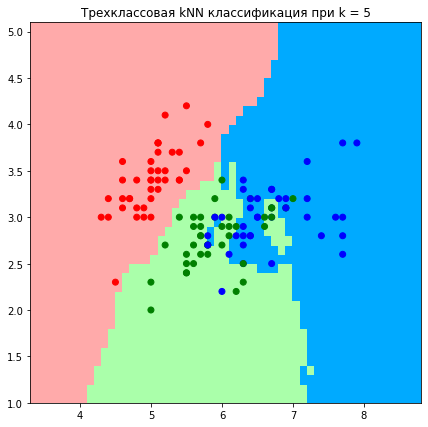

CPU times: user 14.2 s, sys: 143 ms, total: 14.3 s
Wall time: 15.2 s


In [ ]:
%%time
get_graph(X_train, y_train, k)

In [51]:
k = 12

y_pred = knn(aX_train, ay_train, aX_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 12: 0.888


(2352, 2)


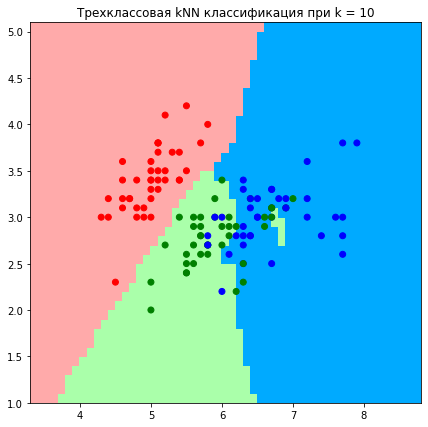

CPU times: user 13.9 s, sys: 75.5 ms, total: 14 s
Wall time: 14.5 s


In [ ]:
%%time
get_graph(X_train, y_train, k)

In [52]:
submit = pd.read_csv('/sample_submission.csv')
submit.head()
# y_pred

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5


In [53]:
submit['Choose'] = y_pred
submit.head()

ValueError: ignored

In [ ]:
submit.to_csv('submit.csv', index=False)

При увеличении k мы на графиках наблюдаем, как алгоритм меньше концентрируется на выбросах, однако, точность на тестовой выборке при этом увеличивается.

Рассматриваемый метод, несмотря на положительные стороны в виде легкости интерпретации, простоты и удобства использования, обладает некоторыми минусами, в частности, он плохо работает на датасетах с большим количеством признаков.

Например, если мы имеем три объекта, при этом второй отличается от первого только значением одного признака, но значительно, а третий отличается от первого незначительно в каждом признаке, расстояния от первого объекта до второго и третьего могут совпадать. Несущественные различия в каждом признаке могут иметь большее значение, чем большое различие в одном признаке. Такое поведение в ряде случаев будет нежелательным. 


In [ ]:
x = np.zeros((2000))
y = np.zeros((2000))
y[2] = 100

e_metrics(x, y)

100.0

In [ ]:
x = np.zeros((2000))
z = np.ones((2000))
e_metrics(x, z)

44.721359549995796

Второй пример - случай, когда количество признаком сравнимо с количеством объектов. В этом случае может возникнуть ситуация, когда расстояния между любыми двумя объектами почти одинаковы. В двумерном пространстве (на плоскости) три точки могут располагаться по вершинам равностороннего треугольника, при этом расстояния между ними будут равны; в трехмерном пространстве то же самое справедливо для четырех точек на вершинах тетраэдра - расстояние между любыми двумя точками будет одинаково. В общем случае это означает, что в $n$-мерном пространстве можно выбрать $n+1$ точку так, чтобы расстояние между любыми двумя точками было одинаковым.

<img src='images/trtet.png' width=400px>

Третий пример - так называемое "проклятие размерности". Суть его заключается в том, что при наличии $n$ бинарных признаков в пространстве признаков будет возможно $2^{n}$ различных объектов вида $x = (0,1,0,0,1,...,1)$, и размер обучающей выборки, необходимый, чтобы описать все пространство объектов (то есть все возможные комбинации таких признаков) также будет порядка $2^{n}$. Чтобы покрыть не все пространство, а долю объектов $\alpha$ (то есть долю объема $\alpha$) нужно будет описать гиперкуб с длиной ребра $e_{p} = \alpha^{n}$. Например, в 10-мерном пространстве признаков чтобы покрыть 1% объема нужно взять гиперкуб с длиной $e_{10}(0,01) = 0.63$, то есть взять окрестность длиной больше половины ребра исходного пространства. Чем больше признаков, тем меньше будет область, которая покрывается во время поиска на заданном расстоянии. Таким образом, при сохранении требований по точности нахождения объекта в пространстве, количество требуемых данных для этого при увеличении количества признаков растет экспоненциально (подробнее про это явление см. в доп. материалах).

Рассмотрим для примера куб с ребром 1 и в нем рассмотрим куб с ребром $\frac{1}{2}$. Посмотрим, какую долю он будет занимать в первом кубе.
<img src='images/curse.png' width=400px>

Проект: 
1. https://www.kaggle.com/c/gb-tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/gb-classification-choose-tutors классификация

## Дополнительные матриалы

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)